<a href="https://colab.research.google.com/github/Bara-Elba/50Algorithms/blob/main/preparing_the_dataset_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns

In [2]:
org = pd.read_csv('EURUSD_Candlestick_1h.csv')
data = pd.read_csv('EURUSD_Candlestick_1h.csv')

In [5]:
# org.head()

,Gmt time,Open,High,Low,Close,Volume
0,01.01.2010 00:00:00.000,1.43283,1.43303,1.43224,1.43276,2.194800e+06
1,01.01.2010 01:00:00.000,1.43287,1.43305,1.43206,1.43249,2.013000e+06
2,01.01.2010 02:00:00.000,1.43279,1.43305,1.43218,1.43278,2.509900e+06
3,01.01.2010 03:00:00.000,1.43285,1.43306,1.43181,1.43209,3.281700e+06
4,01.01.2010 04:00:00.000,1.43218,1.43302,1.43182,1.43236,2.625200e+06


In [ ]:
# def prepare_lstm_data(data, input_window=120, prediction_window=30):
#     """
#     Splits the dataset into input sequences and targets for an LSTM model.

#     Parameters:
#         data (pd.DataFrame or np.ndarray): Dataset containing candlestick data (e.g., OHLC).
#         input_window (int): Number of candlesticks used as input for the model.
#         prediction_window (int): Number of candlesticks to predict (max and min values).

#     Returns:
#         tuple: (X, y) where:
#             X (np.ndarray): Input sequences of shape (num_samples, input_window, num_features).
#             y (np.ndarray): Targets of shape (num_samples, 2) for max and min values.
#     """
#     if isinstance(data, pd.DataFrame):
#         data = data.values  # Convert to numpy array if it's a DataFrame

#     X, y = [], []

#     for i in range(len(data) - input_window - prediction_window):
#         # Input sequence of 120 candlesticks
#         input_seq = data[i:i + input_window]
#         # Target max and min for the next 30 candlesticks
#         prediction_seq = data[i + input_window:i + input_window + prediction_window, 1:3]  # Assuming columns 1 (High) and 2 (Low)
#         max_price = np.max(prediction_seq[:, 0])  # Max from High column
#         min_price = np.min(prediction_seq[:, 1])  # Min from Low column

#         X.append(input_seq)
#         y.append([max_price, min_price])

#     return np.array(X), np.array(y)


In [ ]:
# # Convert 'Gmt time' to datetime and process the time column
# org['Gmt time'] = pd.to_datetime(org['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
# org['hour'] = org['Gmt time'].dt.hour / 23.0
# org['day_of_week'] = org['Gmt time'].dt.dayofweek / 6.0
# org['month'] = (org['Gmt time'].dt.month - 1) / 11.0
# data_processed = org.drop(columns=['Gmt time'])  # Drop the original time column

# # Normalize the data
# scaler = MinMaxScaler()
# data_normalized = scaler.fit_transform(data_processed)

In [ ]:
# data_normalized[0]

array([0.8880092 , 0.88672267, 0.89149424, 0.88786294, 0.00318604,
       0.        , 0.66666667, 0.        ])

In [3]:
# # Prepare input and output for the LSTM
# X, y = prepare_lstm_data(data_normalized)

# # Split into train, validation, and test sets
# train_size = int(len(X) * 0.7)
# val_size = int(len(X) * 0.15)

# X_train, y_train = X[:train_size], y[:train_size]
# X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
# X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# # Output dataset shapes
# print(f"Train shape: {X_train.shape}, {y_train.shape}")
# print(f"Validation shape: {X_val.shape}, {y_val.shape}")
# print(f"Test shape: {X_test.shape}, {y_test.shape}")

# day 2

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

def prepare_dataset(df):
    """
    Prepare the dataset by splitting dates and one-hot encoding temporal features.

    Args:
        df (pd.DataFrame): Input DataFrame with 'Gmt time' column

    Returns:
        pd.DataFrame: Processed DataFrame with temporal features
    """
    # Convert 'Gmt time' to datetime
    df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')

    # Extract temporal features
    df['year'] = df['Gmt time'].dt.year
    df['month'] = df['Gmt time'].dt.month
    df['day'] = df['Gmt time'].dt.day
    df['hour'] = df['Gmt time'].dt.hour

    # One-hot encode month (1-12)
    month_dummies = pd.get_dummies(df['month'], prefix='month').astype(int)

    # One-hot encode day (1-31)
    day_dummies = pd.get_dummies(df['day'], prefix='day').astype(int)

    # One-hot encode hour (0-23)
    hour_dummies = pd.get_dummies(df['hour'], prefix='hour').astype(int)

    # Drop original temporal columns except year
    df = df.drop(['month', 'day', 'hour', 'Gmt time'], axis=1)

    # Concatenate one-hot encoded features
    df = pd.concat([df, month_dummies, day_dummies, hour_dummies], axis=1)

    return df

def create_sequences(df, window_size=60, future_steps=10):
    """
    Create sequences for LSTM training with target as max High and min Low of next 5 candlesticks.

    Args:
        df (pd.DataFrame): Processed DataFrame
        window_size (int): Number of time steps to use for input
        future_steps (int): Number of future time steps to predict

    Returns:
        tuple: (X, y) where X is the input sequences and y is the target values
    """
    # Scale the numerical features
    scaler = MinMaxScaler()
    numerical_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'year']
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # Prepare target values (max High and min Low of next 5 candlesticks)
    target_high = df['High'].rolling(window=future_steps, min_periods=1).max().shift(-future_steps)
    target_low = df['Low'].rolling(window=future_steps, min_periods=1).min().shift(-future_steps)

    # Create sequences
    X = []
    y = []

    for i in range(len(df) - window_size - future_steps + 1):
        # Get the window of data
        sequence = df.iloc[i:(i + window_size)]

        # Get the target values
        target = np.array([
            target_high.iloc[i + window_size - 1],
            target_low.iloc[i + window_size - 1]
        ])

        X.append(sequence.values)
        y.append(target)

    return np.array(X), np.array(y)

def split_data(X, y, train_split=0.8, val_split=0.1):
    """
    Split data into train, validation, and test sets.

    Args:
        X (np.array): Input sequences
        y (np.array): Target values
        train_split (float): Proportion of data for training
        val_split (float): Proportion of data for validation

    Returns:
        tuple: (X_train, X_val, X_test, y_train, y_val, y_test)
    """
    # Calculate split indices
    n = len(X)
    train_idx = int(n * train_split)
    val_idx = int(n * (train_split + val_split))

    # Split the data
    X_train = X[:train_idx]
    X_val = X[train_idx:val_idx]
    X_test = X[val_idx:]

    y_train = y[:train_idx]
    y_val = y[train_idx:val_idx]
    y_test = y[val_idx:]

    return X_train, X_val, X_test, y_train, y_val, y_test


In [5]:
# Example usage:
def process_forex_data(csv_path):
    """
    Process forex data from CSV file and prepare it for LSTM training.

    Args:
        csv_path (str): Path to the CSV file

    Returns:
        tuple: Train, validation, and test sets
    """
    # Read the data
    df = pd.read_csv(csv_path)

    # Prepare the dataset
    processed_df = prepare_dataset(df)

    # Create sequences
    X, y = create_sequences(processed_df)

    # Split the data
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
csv_path = 'EURUSD_Candlestick_1h.csv'

X_train, X_val, X_test, y_train, y_val, y_test = process_forex_data(csv_path)

In [20]:
class R2ScoreCallback(Callback):
    """
    Callback to calculate and print R² score after each epoch.
    """
    def __init__(self, validation_data):
        super(R2ScoreCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val, verbose=0)

        # Calculate R² for both outputs
        r2_high = r2_score(y_val[:, 0], y_pred[:, 0])
        r2_low = r2_score(y_val[:, 1], y_pred[:, 1])

        print(f'\nEpoch {epoch + 1}:')
        print(f'R² Score (Max High): {r2_high:.4f}')
        print(f'R² Score (Min Low): {r2_low:.4f}')

        # Add to logs
        logs['val_r2_high'] = r2_high
        logs['val_r2_low'] = r2_low


In [21]:
class ForexLSTM:
    def __init__(self, input_shape):
        """
        Initialize the LSTM model for forex prediction.

        Args:
            input_shape (tuple): Shape of input data (sequence_length, n_features)
        """
        self.model = self._build_model(input_shape)
        self.history = None
        self.scaler = None

    def _build_model(self, input_shape):
        """
        Build and compile the LSTM model.
        """
        model = Sequential([
            # First LSTM layer with return sequences
            LSTM(128, return_sequences=True, input_shape=input_shape),
            BatchNormalization(),
            Dropout(0.2),

            # Second LSTM layer with return sequences
            LSTM(128, return_sequences=True),
            BatchNormalization(),
            Dropout(0.2),

            # Third LSTM layer
            LSTM(64),
            BatchNormalization(),
            Dropout(0.2),

            # Dense layers for prediction
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dense(2)  # Output layer (max_high, min_low)
        ])

        # Compile model with Huber loss for robustness to outliers
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.Huber(),
            metrics=['mae']
        )

        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=40, batch_size=32):
        """
        Train the model with early stopping and model checkpointing.
        """
        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        checkpoint = ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=0
        )

        # R² score callback
        r2_callback = R2ScoreCallback(validation_data=(X_val, y_val))

        # Train the model
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, checkpoint, r2_callback],
            verbose=1
        )

        return self.history

    def evaluate(self, X_test, y_test):
        """
        Evaluate the model and return various metrics.
        """
        # Make predictions
        y_pred = self.model.predict(X_test)

        # Calculate metrics for both outputs (max_high and min_low)
        metrics = {}
        outputs = ['max_high', 'min_low']

        for i, output in enumerate(outputs):
            metrics[output] = {
                'r2': r2_score(y_test[:, i], y_pred[:, i]),
                'mse': mean_squared_error(y_test[:, i], y_pred[:, i]),
                'rmse': np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i])),
                'mae': mean_absolute_error(y_test[:, i], y_pred[:, i])
            }

        return metrics, y_pred
    def plot_random_predictions(self, X_test, y_test, y_pred, original_data, num_samples=3):
            """
            Plot random predictions with their corresponding input and target candlesticks.

            Args:
                X_test: Test input sequences
                y_test: Actual target values
                y_pred: Predicted target values
                original_data: Original DataFrame with OHLC data
                num_samples: Number of random samples to plot (default=3)
            """
            # Get random indices
            random_indices = np.random.choice(len(y_pred), size=num_samples, replace=False)

            for idx in random_indices:
                plt.figure(figsize=(15, 7))

                # Plot input sequence candlesticks (last 40)
                input_data = X_test[idx]

                # Get the original index for this sequence
                sequence_start_idx = idx  # You'll need to adjust this based on your data structure
                sequence_end_idx = sequence_start_idx + 45  # 40 input + 5 target candlesticks

                # Plot input candlesticks
                for i in range(40):
                    # Plot candlestick
                    plt.vlines(x=i, ymin=input_data[i][2], ymax=input_data[i][1], color='black')
                    # Plot body
                    body_bottom = min(input_data[i][0], input_data[i][3])
                    body_top = max(input_data[i][0], input_data[i][3])
                    plt.vlines(x=i, ymin=body_bottom, ymax=body_top, color='black', linewidth=4)

                # Plot target zone candlesticks
                for i in range(40, 45):
                    plt.vlines(x=i, ymin=original_data.iloc[sequence_start_idx + i]['Low'],
                            ymax=original_data.iloc[sequence_start_idx + i]['High'], color='black')
                    # Plot body
                    body_bottom = min(original_data.iloc[sequence_start_idx + i]['Open'],
                                    original_data.iloc[sequence_start_idx + i]['Close'])
                    body_top = max(original_data.iloc[sequence_start_idx + i]['Open'],
                                original_data.iloc[sequence_start_idx + i]['Close'])
                    plt.vlines(x=i, ymin=body_bottom, ymax=body_top, color='black', linewidth=4)

                # Plot predicted max and min lines in the target zone
                plt.axhline(y=y_pred[idx][0], color='green', linestyle='--',
                          xmin=40/45, label='Predicted Max High')
                plt.axhline(y=y_pred[idx][1], color='red', linestyle='--',
                          xmin=40/45, label='Predicted Min Low')

                # Plot actual max and min lines
                plt.axhline(y=y_test[idx][0], color='green', linestyle='-',
                          xmin=40/45, label='Actual Max High')
                plt.axhline(y=y_test[idx][1], color='red', linestyle='-',
                          xmin=40/45, label='Actual Min Low')

                # Customize plot
                plt.title(f'Prediction Analysis - Sample {idx}')
                plt.xlabel('Candlestick Index')
                plt.ylabel('Price')
                plt.legend()
                plt.grid(True, alpha=0.3)

                # Add vertical line separator between input and target zones
                plt.axvline(x=40, color='gray', linestyle='--', alpha=0.5)
                plt.text(20, plt.ylim()[1], 'Input Zone', horizontalalignment='center')
                plt.text(42, plt.ylim()[1], 'Target Zone', horizontalalignment='center')

                plt.tight_layout()
                plt.show()

                # Print prediction metrics for this sample
                print(f"\nSample {idx} Metrics:")
                print(f"Max High - Actual: {y_test[idx][0]:.5f}, Predicted: {y_pred[idx][0]:.5f}, "
                      f"Error: {abs(y_test[idx][0] - y_pred[idx][0]):.5f}")
                print(f"Min Low  - Actual: {y_test[idx][1]:.5f}, Predicted: {y_pred[idx][1]:.5f}, "
                      f"Error: {abs(y_test[idx][1] - y_pred[idx][1]):.5f}")
                print("-" * 80)

    def plot_training_history(self):
        """
        Plot training history including loss and metrics.
        """
        plt.figure(figsize=(15, 5))

        # Plot training & validation loss
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot training & validation MAE
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['mae'], label='Training MAE')
        plt.plot(self.history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, y_test, y_pred, subset_size=100):
        """
        Plot actual vs predicted values for both outputs.
        """
        plt.figure(figsize=(15, 10))

        # Plot max_high predictions
        plt.subplot(2, 1, 1)
        plt.plot(y_test[:subset_size, 0], label='Actual Max High', alpha=0.7)
        plt.plot(y_pred[:subset_size, 0], label='Predicted Max High', alpha=0.7)
        plt.title('Max High: Actual vs Predicted')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()

        # Plot min_low predictions
        plt.subplot(2, 1, 2)
        plt.plot(y_test[:subset_size, 1], label='Actual Min Low', alpha=0.7)
        plt.plot(y_pred[:subset_size, 1], label='Predicted Min Low', alpha=0.7)
        plt.title('Min Low: Actual vs Predicted')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_residuals(self, y_test, y_pred):
        """
        Plot residual analysis for both outputs.
        """
        plt.figure(figsize=(15, 10))

        # Residuals for max_high
        residuals_high = y_test[:, 0] - y_pred[:, 0]
        plt.subplot(2, 2, 1)
        sns.histplot(residuals_high, kde=True)
        plt.title('Residuals Distribution (Max High)')
        plt.xlabel('Residual')

        plt.subplot(2, 2, 2)
        plt.scatter(y_pred[:, 0], residuals_high, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals vs Predicted (Max High)')
        plt.xlabel('Predicted Value')
        plt.ylabel('Residual')

        # Residuals for min_low
        residuals_low = y_test[:, 1] - y_pred[:, 1]
        plt.subplot(2, 2, 3)
        sns.histplot(residuals_low, kde=True)
        plt.title('Residuals Distribution (Min Low)')
        plt.xlabel('Residual')

        plt.subplot(2, 2, 4)
        plt.scatter(y_pred[:, 1], residuals_low, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals vs Predicted (Min Low)')
        plt.xlabel('Predicted Value')
        plt.ylabel('Residual')

        plt.tight_layout()
        plt.show()

In [22]:

# Example usage
def train_and_evaluate_model(X_train, X_val, X_test, y_train, y_val, y_test):
    """
    Train and evaluate the LSTM model with full analysis.
    """
    # Initialize model
    model = ForexLSTM(input_shape=(X_train.shape[1], X_train.shape[2]))

    # Train model
    history = model.train(X_train, y_train, X_val, y_val)

    # Evaluate model
    metrics, y_pred = model.evaluate(X_test, y_test)

    # Plot training history
    model.plot_training_history()

    # Plot predictions
    model.plot_predictions(y_test, y_pred)

    # Plot residuals
    model.plot_residuals(y_test, y_pred)

    # Print metrics
    print("\nModel Performance Metrics:")
    for output, metrics_dict in metrics.items():
        print(f"\n{output.upper()}:")
        for metric, value in metrics_dict.items():
            print(f"{metric}: {value:.4f}")

    return model, metrics, y_pred

In [23]:
# Initialize model
model = ForexLSTM(input_shape=(X_train.shape[1], X_train.shape[2]))

# Train model
history = model.train(X_train, y_train, X_val, y_val, epochs=4, batch_size=256)

Epoch 1/4
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1552 - mae: 0.3952
Epoch 1:
R² Score (Max High): -0.1051
R² Score (Min Low): -2.4263
293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - loss: 0.1545 - mae: 0.3940 - val_loss: 0.0077 - val_mae: 0.1018 - val_r2_high: -0.1051 - val_r2_low: -2.4263
Epoch 2/4
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0069 - mae: 0.0922
Epoch 2:
R² Score (Max High): 0.3400
R² Score (Min Low): 0.3156
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - loss: 0.0069 - mae: 0.0921 - val_loss: 0.0023 - val_mae: 0.0506 - val_r2_high: 0.3400 - val_r2_low: 0.3156
Epoch 3/4
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0035 - mae: 0.0654
Epoch 3:
R² Score (Max High): 0.4516
R² Score (Min Low): 0.2465
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0035 - mae: 0.0654 - val_loss: 0.0022 - val_mae: 0.0467 - val_r2_high: 0.4516 - val_r2_low: 0.2465
Epoch 4/4
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0023 - mae: 0.0529
Epoch 4:
R² Score (Max H

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


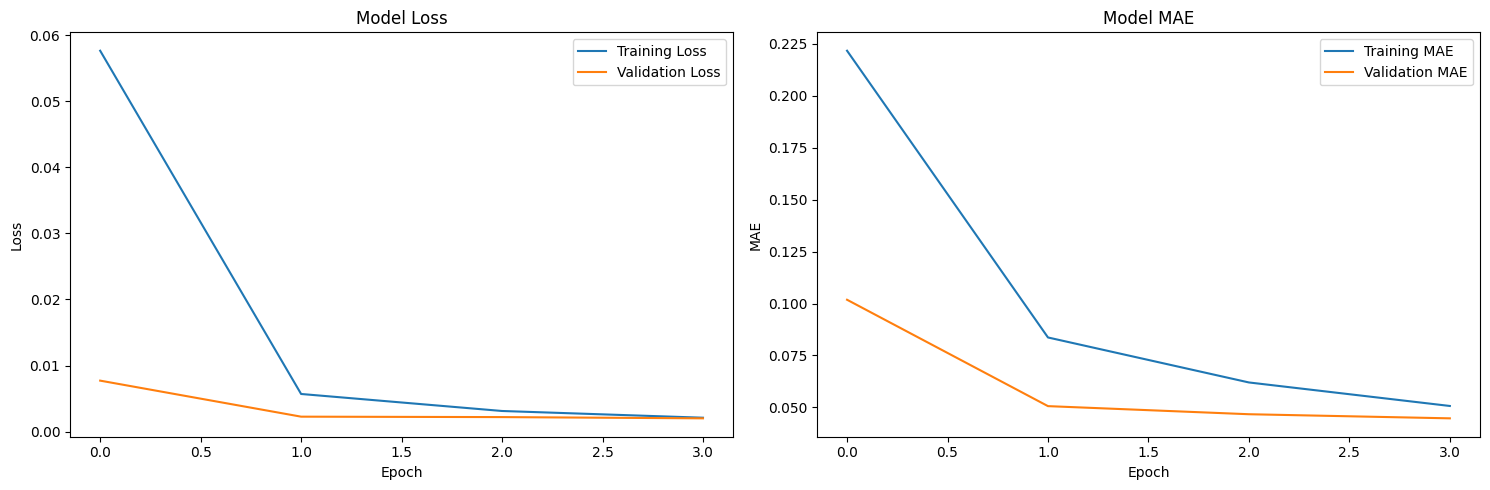

In [24]:
# Evaluate model
metrics, y_pred = model.evaluate(X_test, y_test)

# Plot training history
model.plot_training_history()

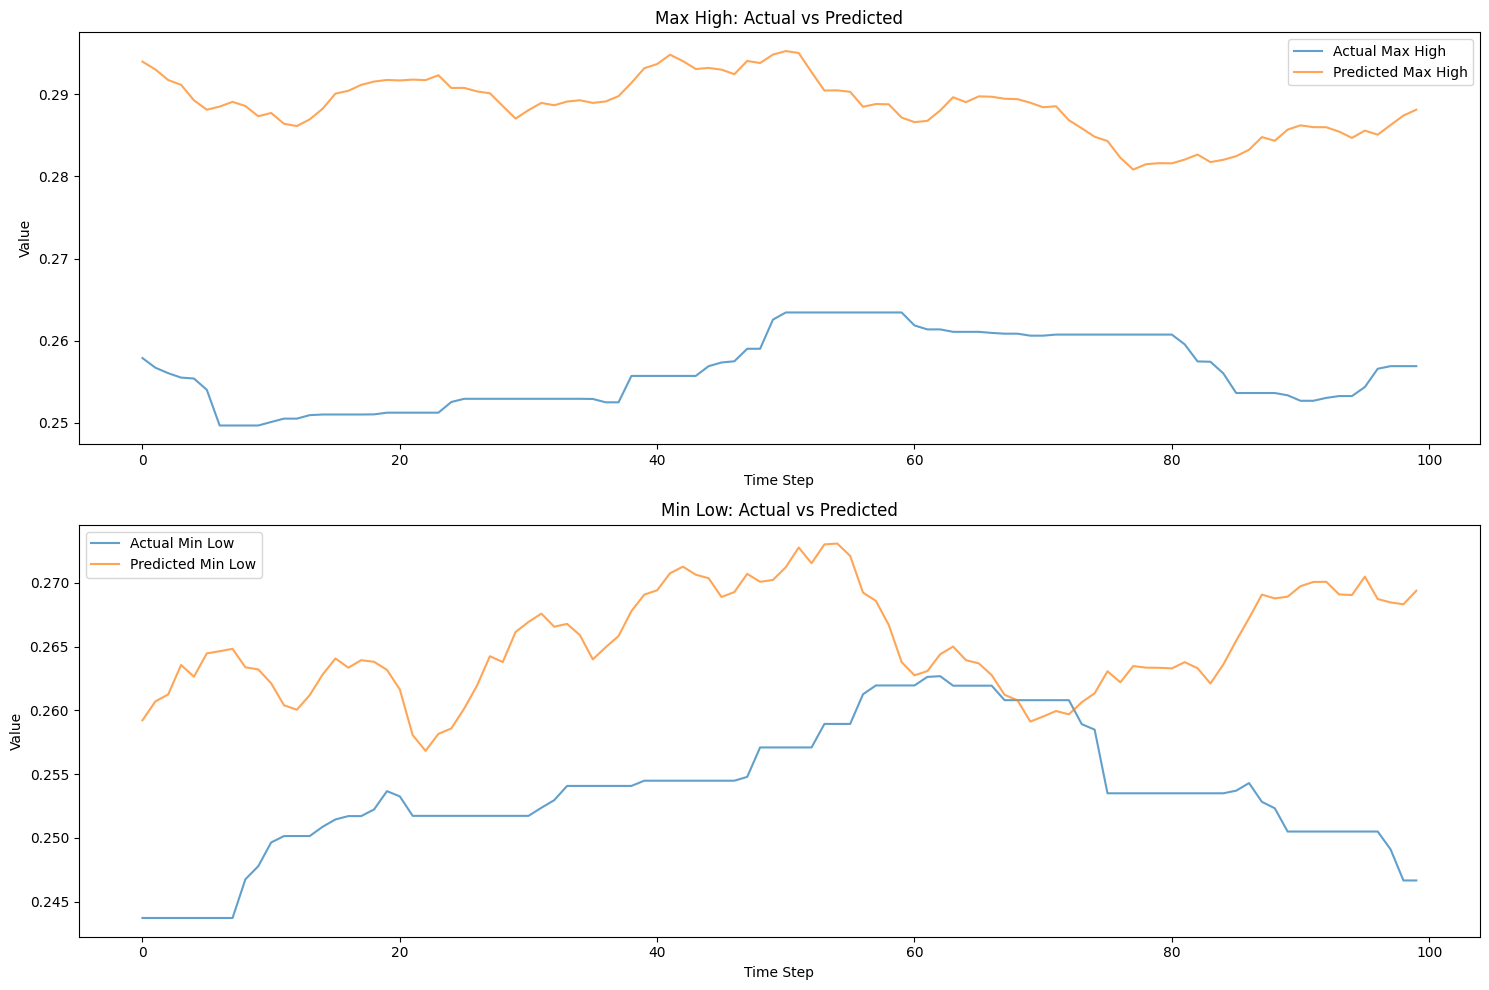

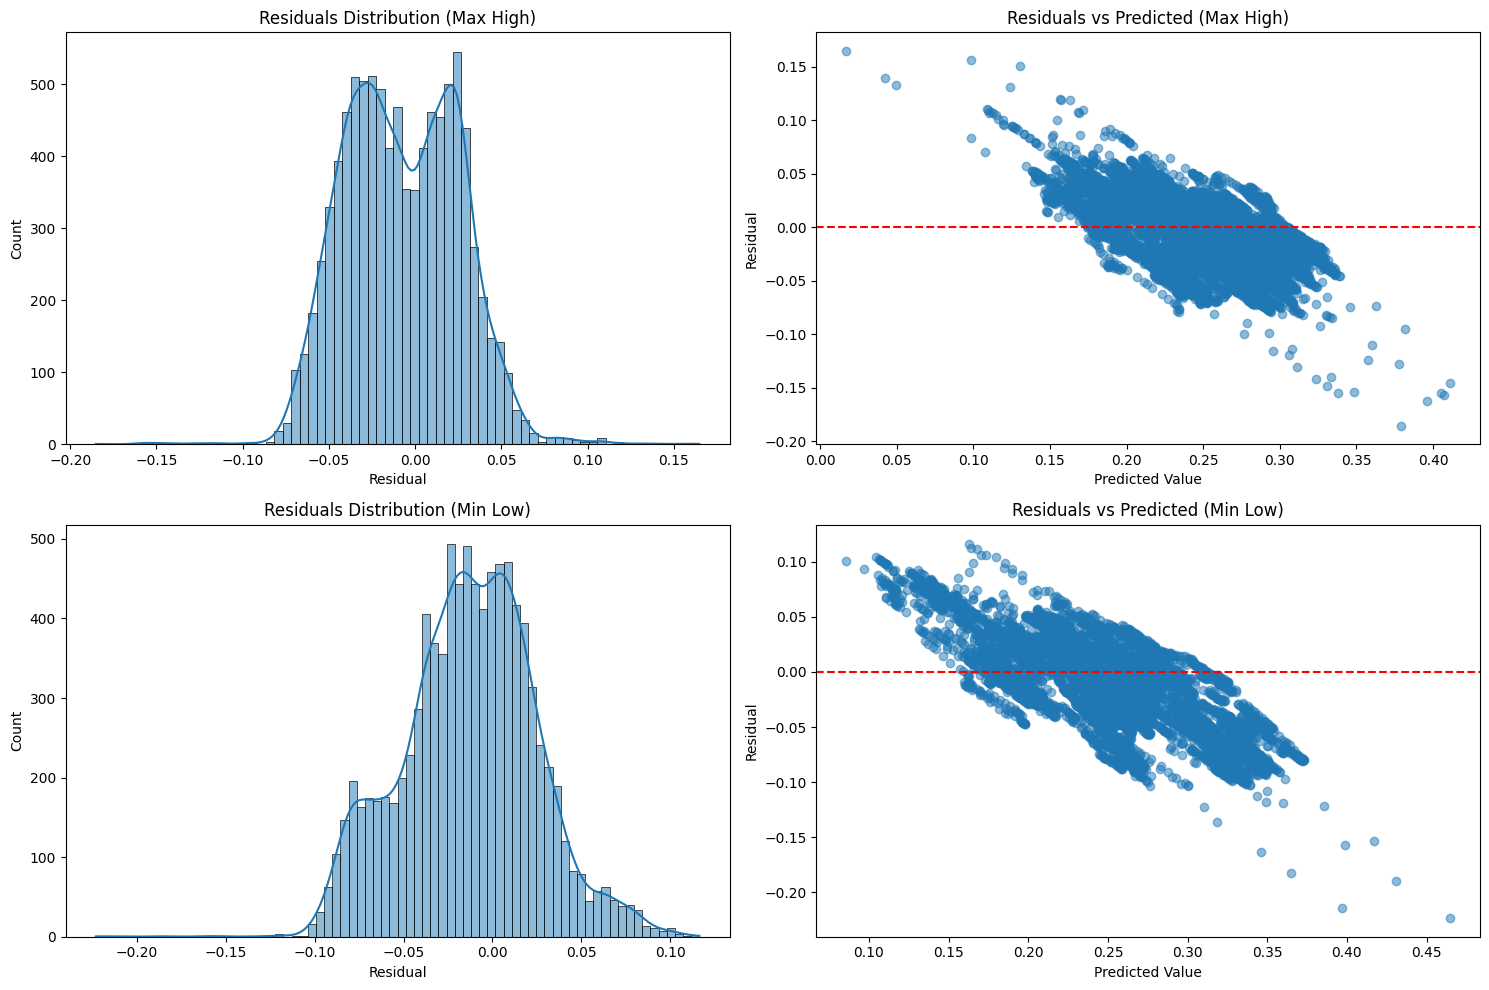

In [25]:
# Plot predictions
model.plot_predictions(y_test, y_pred)

# Plot residuals
model.plot_residuals(y_test, y_pred)


In [26]:
# Print metrics
print("\nModel Performance Metrics:")
for output, metrics_dict in metrics.items():
    print(f"\n{output.upper()}:")
    for metric, value in metrics_dict.items():
        print(f"{metric}: {value:.4f}")


Model Performance Metrics:

MAX_HIGH:
r2: -0.1282
mse: 0.0011
rmse: 0.0338
mae: 0.0282

MIN_LOW:
r2: -0.5199
mse: 0.0016
rmse: 0.0398
mae: 0.0313


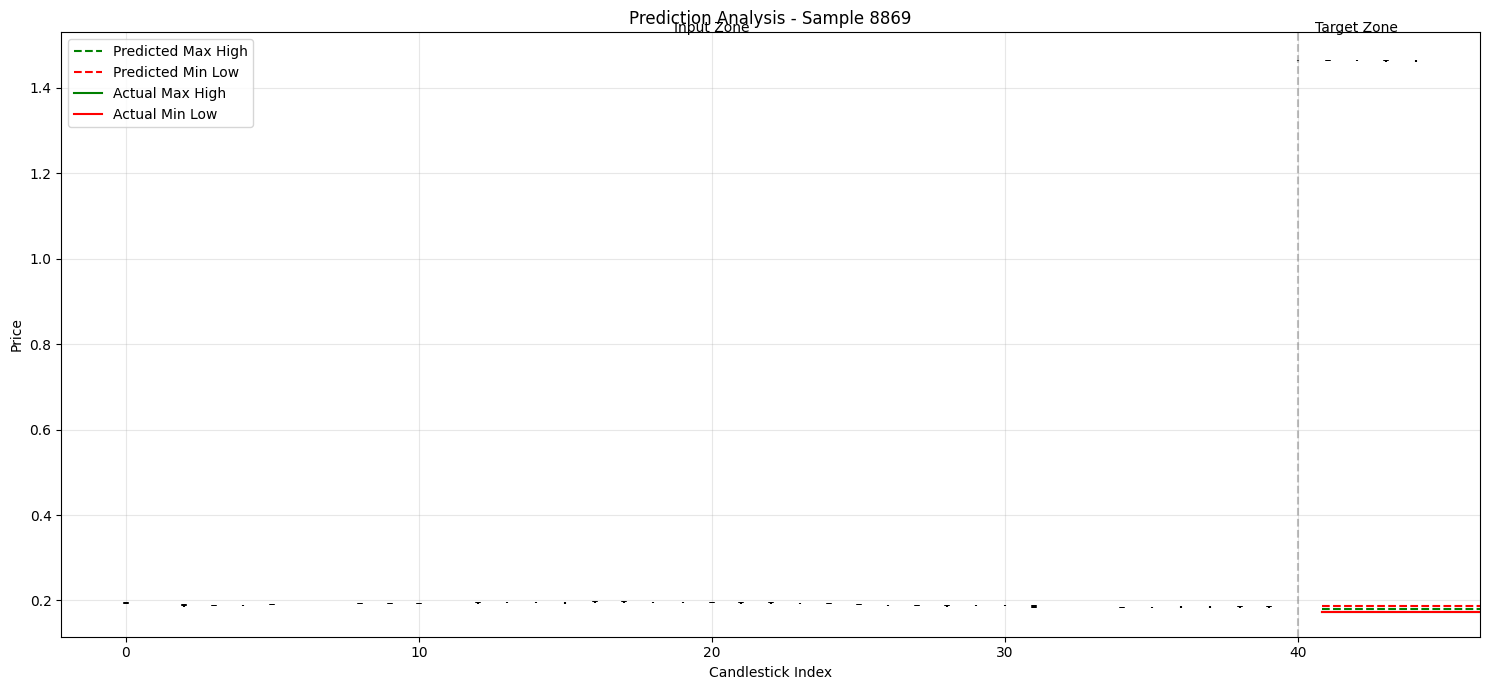


Sample 8869 Metrics:
Max High - Actual: 0.17247, Predicted: 0.17987, Error: 0.00740
Min Low  - Actual: 0.17332, Predicted: 0.18598, Error: 0.01266
--------------------------------------------------------------------------------


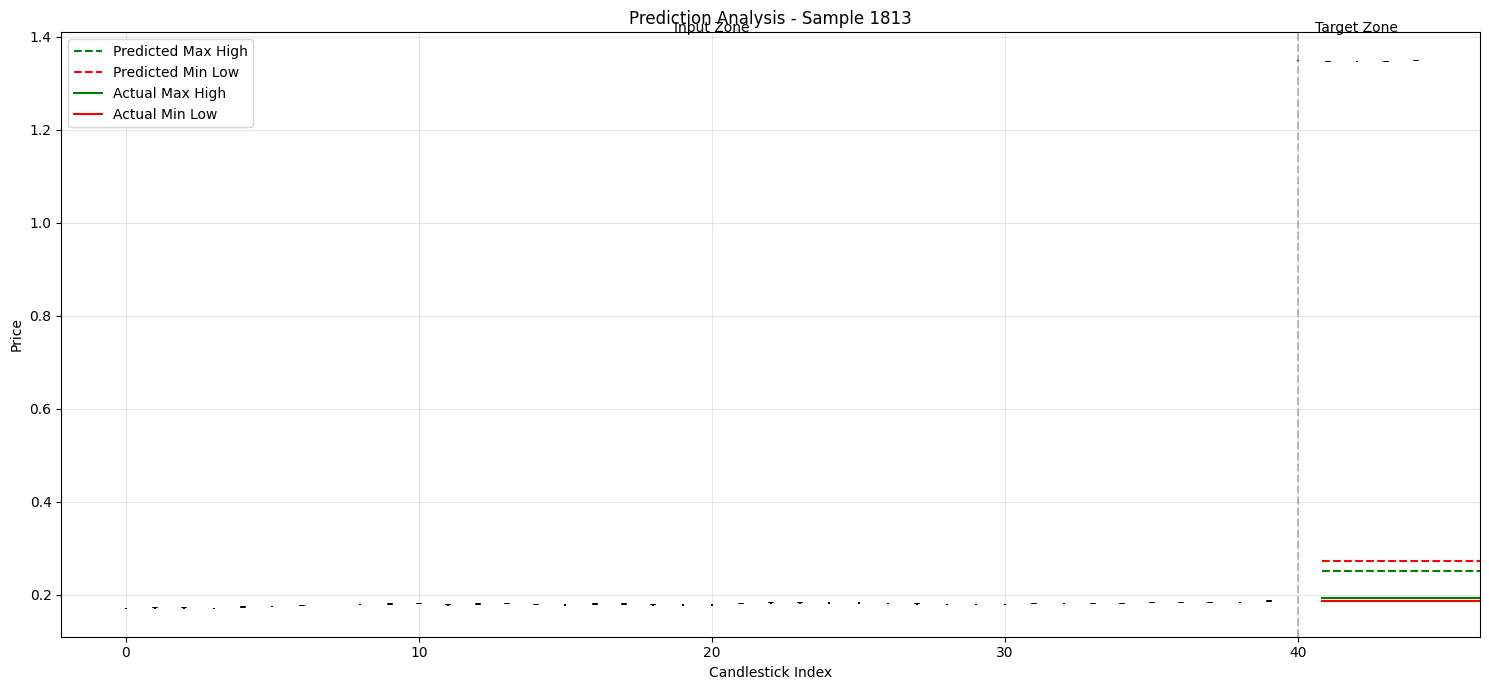


Sample 1813 Metrics:
Max High - Actual: 0.19342, Predicted: 0.25008, Error: 0.05666
Min Low  - Actual: 0.18630, Predicted: 0.27289, Error: 0.08659
--------------------------------------------------------------------------------


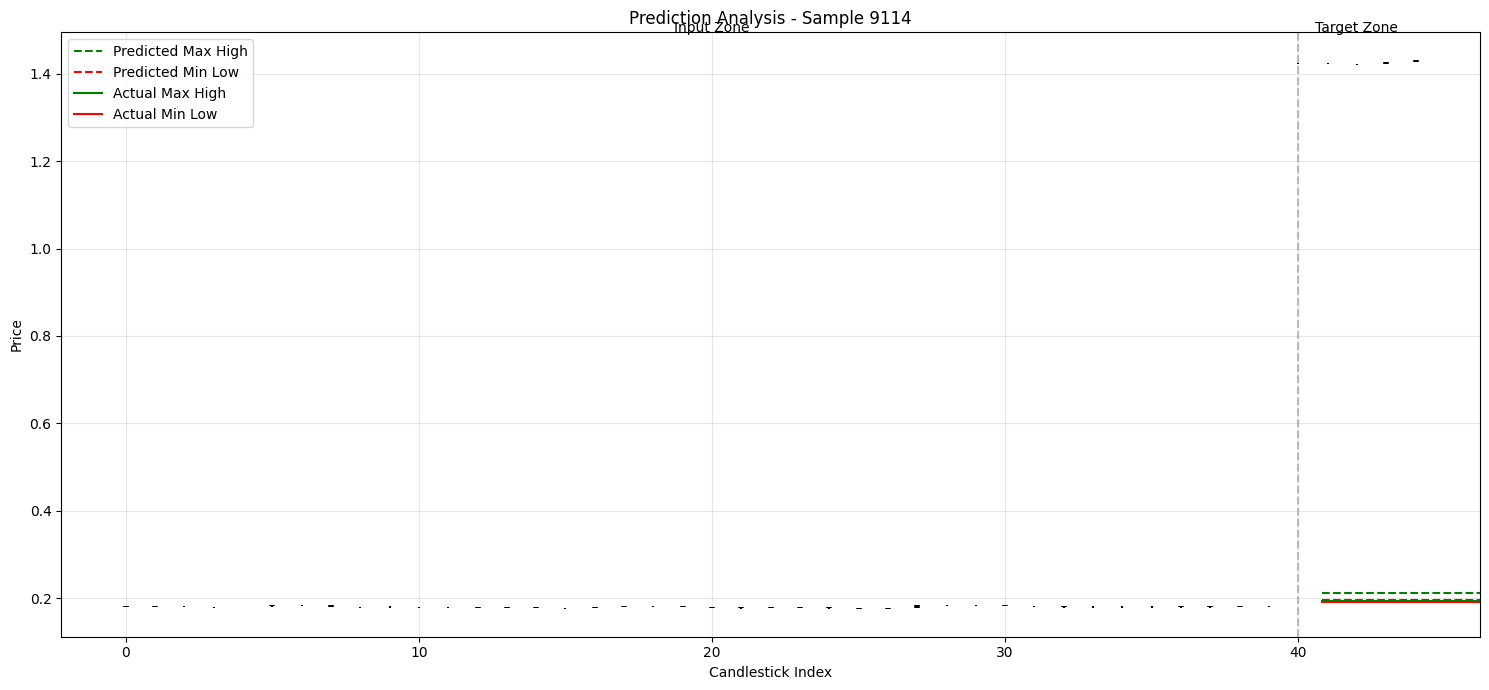


Sample 9114 Metrics:
Max High - Actual: 0.19232, Predicted: 0.21175, Error: 0.01943
Min Low  - Actual: 0.19187, Predicted: 0.19626, Error: 0.00439
--------------------------------------------------------------------------------


In [27]:
model.plot_random_predictions(
    X_test,
    y_test,
    y_pred,
    data,  # Your original DataFrame with OHLC data
    num_samples=3   # Number of random samples to visualize
)

In [29]:
X_train[0][0]

array([0.8880092 , 0.88672267, 0.89149424, 0.88786294, 0.00318604,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])